# Hands-On ARIMA
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%201%20-%20Time%20Series/arima.ipynb)

En este notebook se trabajarán ejemplos prácticos de los modelos ARIMA vistos en la lectura teórica. En esta actividad empezaremos a conectar con conceptos y métricas con las que luego podrémos hacer comparaciones de rendimiento cuando veamos los modelos basados en Deep Learning. Esto último será muy útil ya que contaremos con la capacidad de comparar soluciones distintas al mismo problema.

Primero, vamos a generar un dataset sintético que tiene estos mismos patrónes y procederémos a entrenar un modelo para recuperar los coeficientes del proceso.

Vamos a simular in proceso que obedece a los siguientes parámetros:

$$ y_t = -0.63y_{t-1} + 0.38y_{t-2} + 0.24\epsilon_{t-1} + 0.72\epsilon_{t-2}$$

Adicional a ello, vamos a aplicar una tendencia sintética con una función cuadrática:

$$ f(x) = (2\times10^{-7}) x^2$$

In [1]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [2]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/requirements.txt  && pip install -r requirements.txt

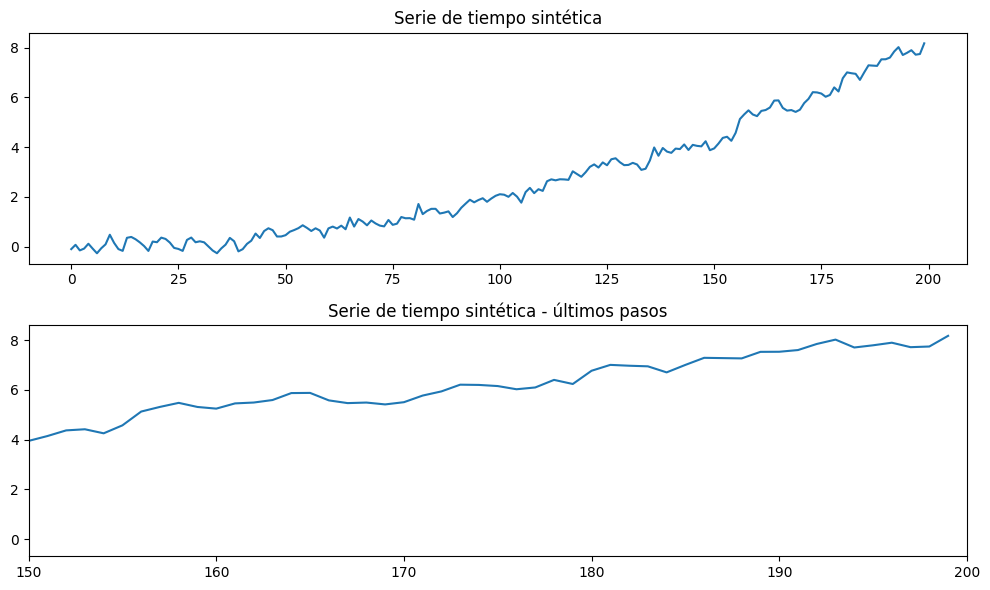

In [3]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
import numpy as np

np.random.seed(1234)

n_samples = 200

# generamos la serie según los parámetros que hemos definido
ar_component = sm.tsa.arma_generate_sample([-0.63, 0.48], [1], n_samples, scale=0.1)
ma_component = sm.tsa.arma_generate_sample([1], [0.63, 0.48], n_samples, scale=0.1)
trend_component = 0.0002 * np.arange(n_samples)**2

time_series = ar_component + ma_component + trend_component

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(time_series)
ax1.set_title("Serie de tiempo sintética")

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(time_series)
ax2.set_xlim(n_samples - (n_samples // 4), n_samples)
ax2.set_title("Serie de tiempo sintética - últimos pasos")

plt.tight_layout()
plt.show()

Graficamos el ACF y PACF para convencernos de que la serie tiene componentes auto-regresivos y promédio móvil.

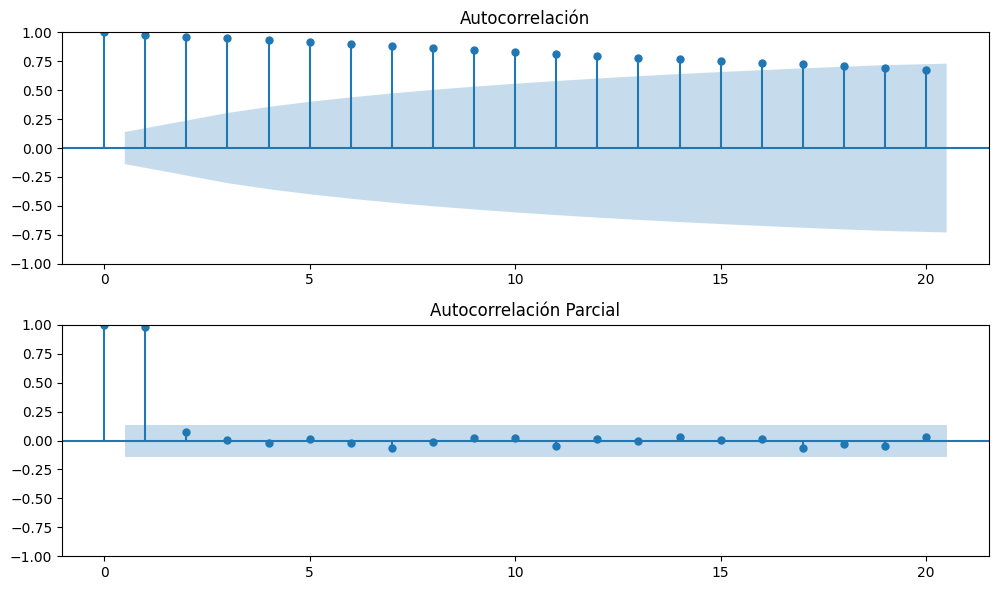

In [4]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(time_series, lags=20, title="Autocorrelación", ax=ax1)
plot_pacf(time_series, lags=20, title="Autocorrelación Parcial", ax=ax2)
plt.tight_layout()
plt.show()

Como podemos observar, ninguno de las funciones nos indica con certeza el orden de ninguno de los procesos. Pero lo primero que debemos hacer es remover la dendencia mediante diferenciación:

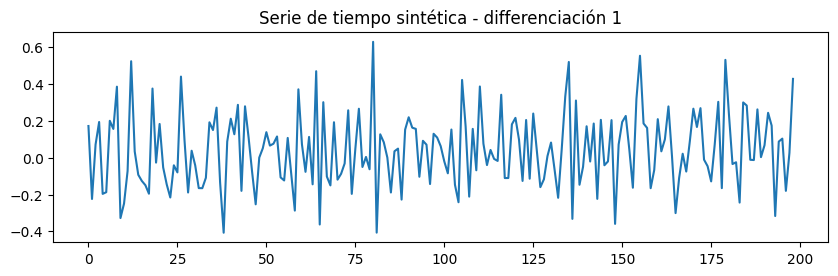

In [5]:
detrend_ts = np.diff(time_series, 1)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(detrend_ts)
ax1.set_title("Serie de tiempo sintética - differenciación 1")
plt.show()

Luce bien, pero debemos ser precisos y comprobar que es ahora una serie estacionaria, para ello aplicamos un Ad-Füller test.

In [6]:
from statsmodels.tsa.stattools import adfuller

ad_fuller_result = adfuller(detrend_ts)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -9.509444288606662
p-value: 3.279397640684513e-16


Hemos obtenido in estadístico negativo, buena señal. Pero lo importante es el $p-valor$, que es inferior a $0.05$ lo cual nos indica que la serie ahora es estacionaria. Podemos continuar con el proceso.

**Para tener en cuenta:** Hemos transformado la serie y la hemos diferenciado una vez, este será nuestro parámetro de integración en el modelo $ARIMA$.

## Proceso de optimización
Ahora viene el proceso de optimización para hallar los mejores ordenes para los procesos AR y MA. Esto podemos hacerlo mediante un proceso iterativo de fuerza bruta.

In [7]:
import tqdm
from typing import Tuple, List, Any
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

# Ignoramos esta advertencia ya que esperamos que algunas configuraciones
# no lleguen a convergencia.
warnings.simplefilter("ignore", ConvergenceWarning)

def optimizeARIMA(data: np.ndarray, orders: List[Tuple[int]], criteria: str = "aic") -> (float, Tuple[int]):

    best_criteria = float("inf")
    best_order = None

    with tqdm.tqdm(total = len(orders)) as progress:
        for order in orders:
            try:
                model = SARIMAX(data, order=order, simple_differencing=False).fit(disp=False)
                # obtenemos el criterio AIC de estos parámetros
                if criteria == "aic":
                    criteria_val = model.aic
                elif criteria == "bic":
                    criteria_val = model.bic
                if criteria_val < best_criteria:
                    best_criteria = criteria_val
                    best_order = order
            except Exception as e:
                # Configuración inválida de modelo, es seguro ignorar
                continue
            finally:
                progress.update()

    return best_criteria, best_order


In [8]:
%%time
from itertools import product

ps = range(8)
d = [1]
qs = range(8)

orders = list(product(ps, d, qs))

aic, best_orders = optimizeARIMA(time_series, orders)
print(20 * "#")
print(f"Los mejores parámetros son: {best_orders}, con un aic de: {aic}")
print(20 * "#")

100%|██████████| 64/64 [00:45<00:00,  1.41it/s]

####################
Los mejores parámetros son: (2, 1, 3), con un aic de: -84.67457884578289
####################
CPU times: user 2min 10s, sys: 2min 9s, total: 4min 19s
Wall time: 45.5 s


Hemos obtenido un resultado interesante!

Recordemos que inicialmente definimos un proceso de orden 2 tanto para AR como MA. Sin embargo, hemos obtenido unos órdenes diferentes en el resultado. Esto puede deberse a múltiples factores, como por ejemplo la aleatoredad en los datos, el algoritmo interno de SARIMAX, o el producto de la interacción de los tres componentes. Lo que nos debe importar es si estos parámetros realmente explican el comportamiento de la serie.

Entonces, primero inicialicemos nuestro modelo con los parámetros encontrados:


In [9]:
best_model = SARIMAX(time_series, order=best_orders, simple_differencing=False)
res = best_model.fit(disp=False)
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(2, 1, 3)   Log Likelihood                  48.337
Date:                Sat, 24 Feb 2024   AIC                            -84.675
Time:                        12:22:48   BIC                            -64.915
Sample:                             0   HQIC                           -76.677
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6043      0.143     11.189      0.000       1.323       1.885
ar.L2         -0.6051      0.144     -4.207      0.000      -0.887      -0.323
ma.L1         -1.8613      0.161    -11.555      0.0

Observemos que casi todos los coeficientes obtenidos, el $p-valor$ obtenido es inferior a 0.05, lo cual nos indica que este conjunto de parámetros, estadísticamente hablando, es capaz de explicar la dinámica de la serie. Observemos otros parámetros estadísticos antes de pasar a la métrica MSE.

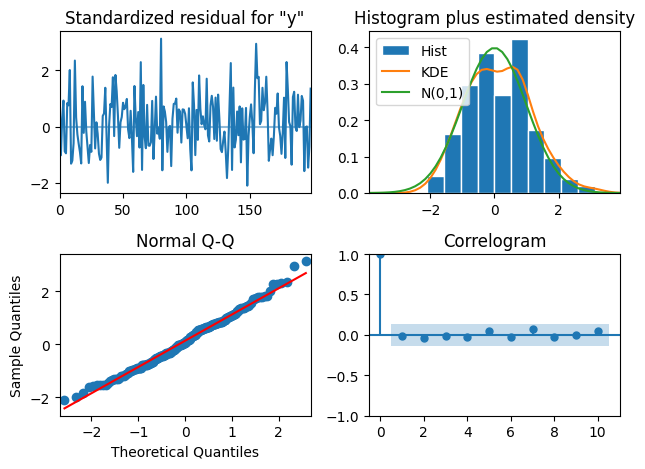

In [10]:
res.plot_diagnostics()
plt.tight_layout()
plt.show()

Tal como hemos comentado en las lecciones anteriores, vemos que los errores se comportan de forma normal, por lo que parece que este modelo es de buena calidad.

Ahora, para hacer una verificación final, hagámos uso de una métrica con la que ya deberíamos estar familiarizados, $MSE$ o Mean Squared Error.

$$
MSE(y,ARIMA(p, d, q)(x))=\frac{1}{m}\sum_{i=1}^{m} (ARIMA(p, d, q)(x^{(i)}) - y^{(i)})^2
$$


In [11]:
import pandas as pd
from sklearn.metrics import mean_squared_error

n_forecast = 10
predict = res.get_prediction(end=best_model.nobs + n_forecast)
predictions = predict.predicted_mean

data = pd.DataFrame({'data': time_series, 'predictions': predictions[:-(n_forecast+1)]})
mse = mean_squared_error(data['data'], data['predictions'])
print(f"MSE contra los datos: {mse:.5f}")
data.head(15)

MSE contra los datos: 0.03599


,data,predictions
0,-0.094963,0.000000
1,0.077831,-0.094963
2,-0.145889,0.062610
3,-0.073663,-0.137217
4,0.120973,-0.068373
5,-0.075053,0.104159
6,-0.261966,-0.068499
7,-0.060769,-0.231510
8,0.096106,-0.057656
9,0.482666,0.074934


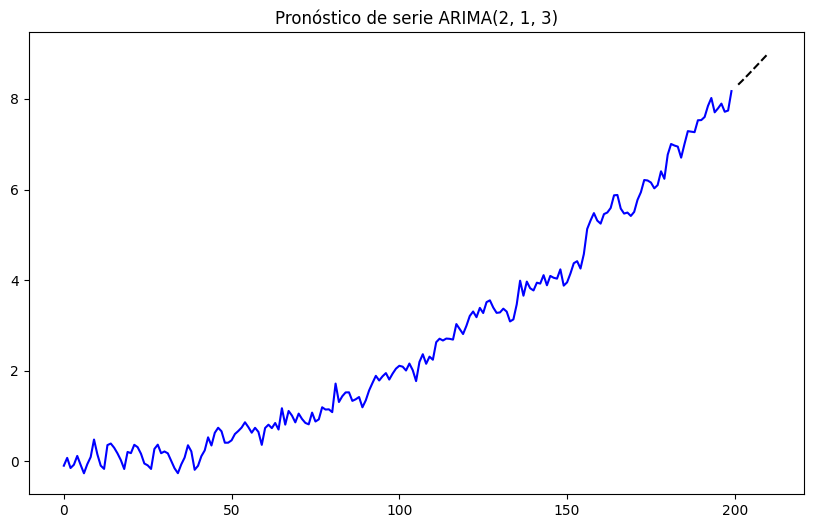

In [12]:
idx = np.arange(len(predict.predicted_mean))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(data['data'], 'blue', label='Serie')
ax.plot(idx[-n_forecast:], predictions[-n_forecast:], 'k--', label='Pronóstico')
ax.set_title('Pronóstico de serie ARIMA(2, 1, 3)')
plt.show()

Aquí vemos que los pronósticos comienzan a obedecer los patrones de la serie. Aunque en este caso particular, puede que por aleatoridades del proceso, no se logre capturar el ruido de la misma.

Ahora vamos a ver el modelo en acción con datos reales:

### De vuelta al caso del Shampoo
Recordemos la primera lección del curso. En ella exploramos el conjunto de datos de ventas de shampoo e intentamos ajustar un modelo de regresión lineal simple, el cual no resultó muy bueno. Ahora miremos como se comporta el modelo ARIMA en este caso.

In [13]:
!test '{IN_COLAB}' = 'True' && mkdir -p datasets/ && wget https://github.com/Ohtar10/icesi-advanced-dl/raw/main/datasets/shampoo_sales.csv -O datasets/shampoo_sales.csv

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.linear_model import LinearRegression

import statsmodels.api as sm

warnings.simplefilter(action="ignore", category=FutureWarning)

# Cambiar según la localización del archivo.
if IN_COLAB:
  dataset_path = './datasets/shampoo_sales.csv'
else:
  dataset_path = '../datasets/shampoo_sales.csv'

dataset = pd.read_csv(dataset_path)
dataset.head(15)

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3
5,1-06,168.5
6,1-07,231.8
7,1-08,224.5
8,1-09,192.8
9,1-10,122.9


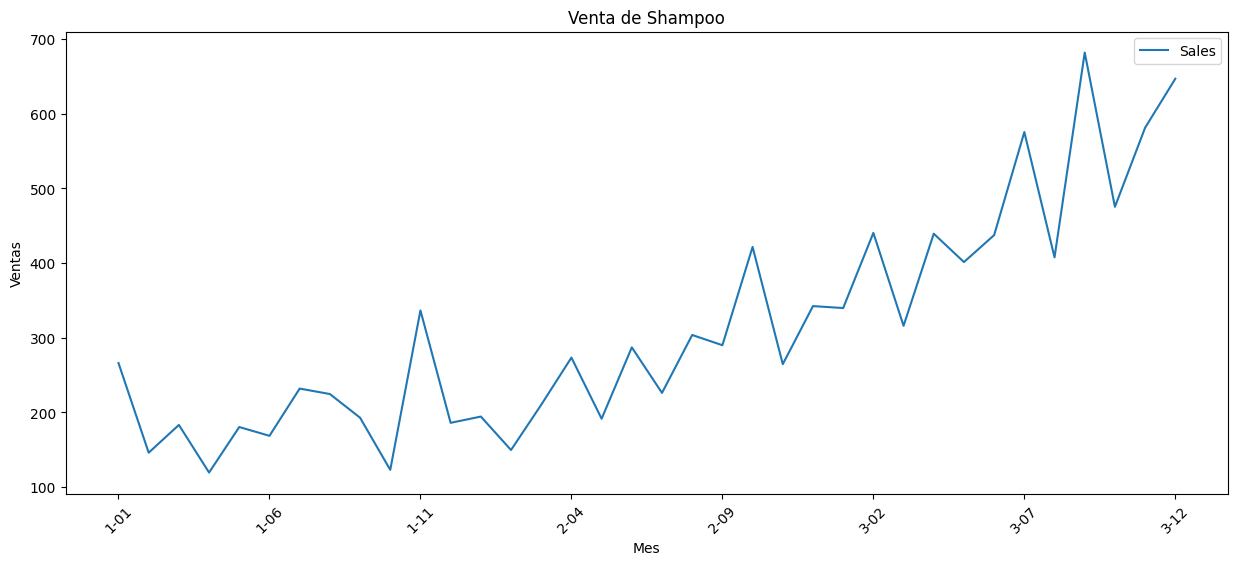

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dataset.plot(x='Month', y='Sales', ax=ax)
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.tick_params(axis='x', labelrotation=45)
plt.title("Venta de Shampoo")
plt.show()

Empecemos por lo que ya sabemos, ACF y PACF para convencernos de que es una serie con características AR y MA.

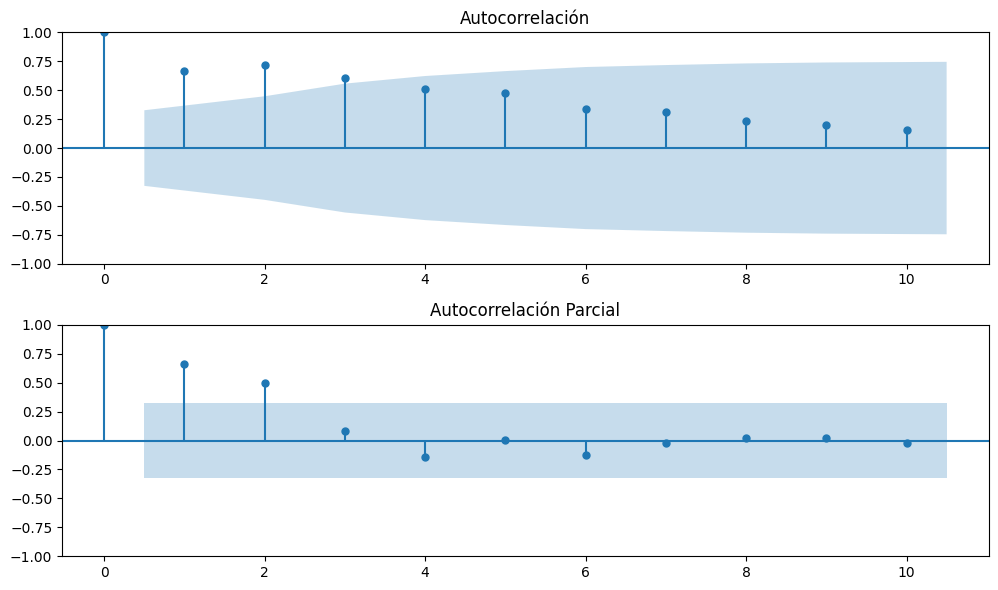

In [16]:
fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(dataset['Sales'], lags=10, title="Autocorrelación", ax=ax1)
plot_pacf(dataset['Sales'], lags=10, title="Autocorrelación Parcial", ax=ax2)
plt.tight_layout()
plt.show()

Vemos los patrónes que nos indican que la serie es AR y MA, verifiquemos además con el Ad-Füller test de que la serie no es estacionaria (debido a su tendencia).



In [17]:
ad_fuller_result = adfuller(dataset['Sales'])
print(f"Estadístico ADF: {ad_fuller_result[0]}, p-valor: {ad_fuller_result[1]:.4f}")

Estadístico ADF: 3.060142083641181, p-valor: 1.0000


Ahora diferenciemos la serie hasta volverla estacionaria.

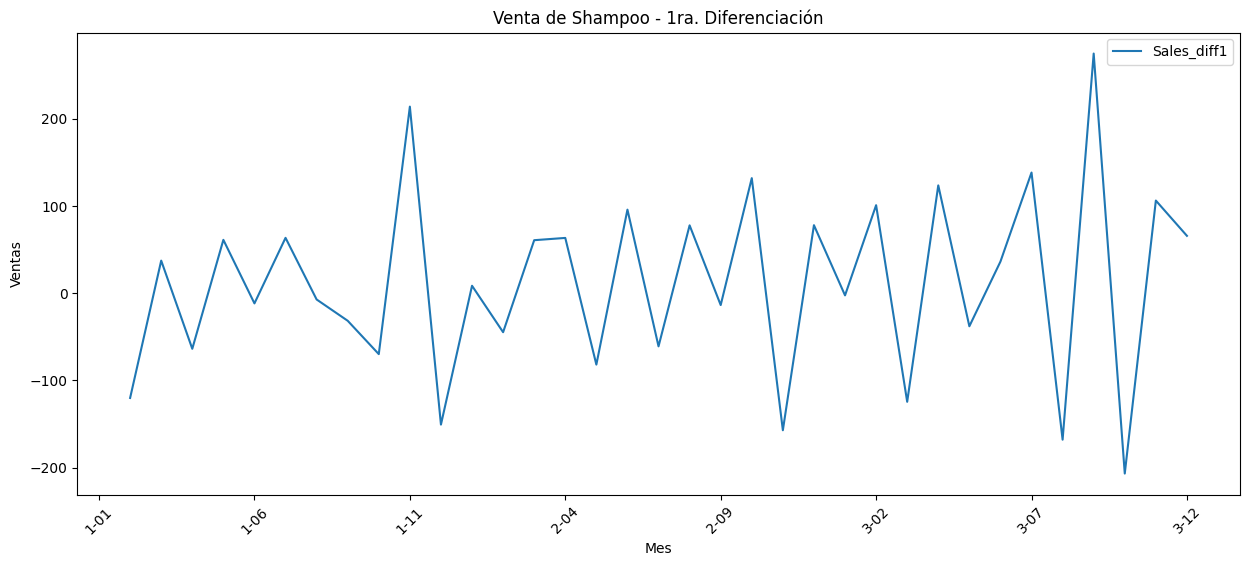

In [18]:
dataset['Sales_diff1'] = dataset['Sales'].diff()

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
dataset.plot(x='Month', y='Sales_diff1', ax=ax)
ax.set_xlabel("Mes")
ax.set_ylabel("Ventas")
ax.tick_params(axis='x', labelrotation=45)
plt.title("Venta de Shampoo - 1ra. Diferenciación")
plt.show()

Estadístico ADF: -7.249074055553854, p-valor: 0.000000


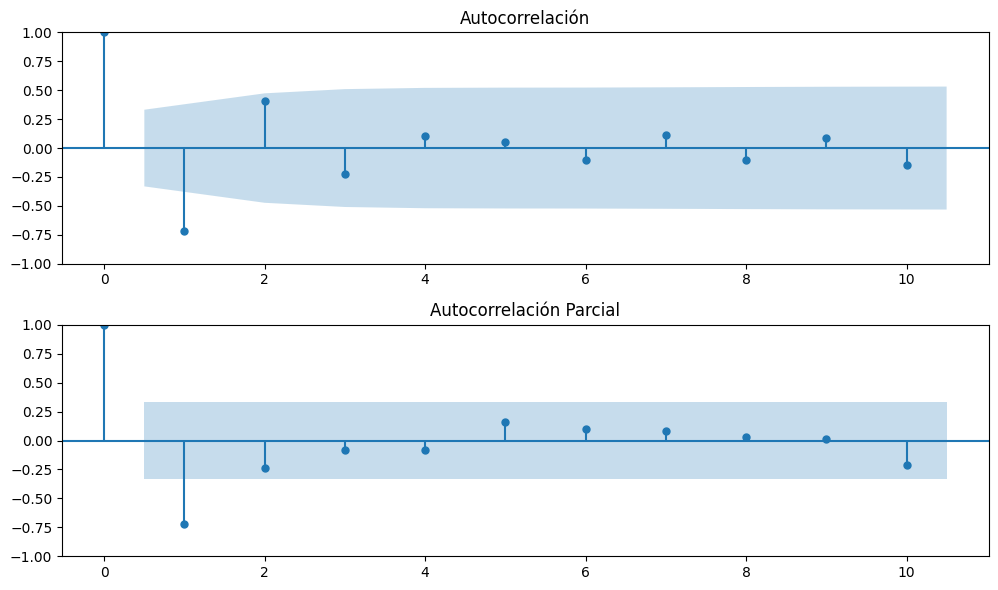

In [19]:
# Recordemos que al diferenciar perdemos el primer dato
ad_fuller_result = adfuller(dataset['Sales_diff1'][1:])
print(f"Estadístico ADF: {ad_fuller_result[0]}, p-valor: {ad_fuller_result[1]:.6f}")

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
plot_acf(dataset['Sales_diff1'][1:], lags=10, title="Autocorrelación", ax=ax1)
plot_pacf(dataset['Sales_diff1'][1:], lags=10, title="Autocorrelación Parcial", ax=ax2)
plt.tight_layout()
plt.show()

Con diferenciar una vez nos ha bastado para remover la tendencia, este será nuestro parámetro $d$ en el modelo.

#### Nota
Encontrar los mejores parámetros exclusivamente a través del AIC no siempre resulta en el mejor modelo para hacer *predicciones*. Es importante validar los resultados antes de seleccionar el modelo. En el caso de las ventas de shampoo, la métrica AIC diría que el mejor modelo es (0, 1, 2), y el MSE lo confirmaría, pero al momento de hacer predicciones, estas no son muy buenas. Se ensayaron otras combinaciones y (5, 1, 0) es quien da mejores resultados haciendo *pronósticos*, a pesar de que las métricas nos digan otra cosa.


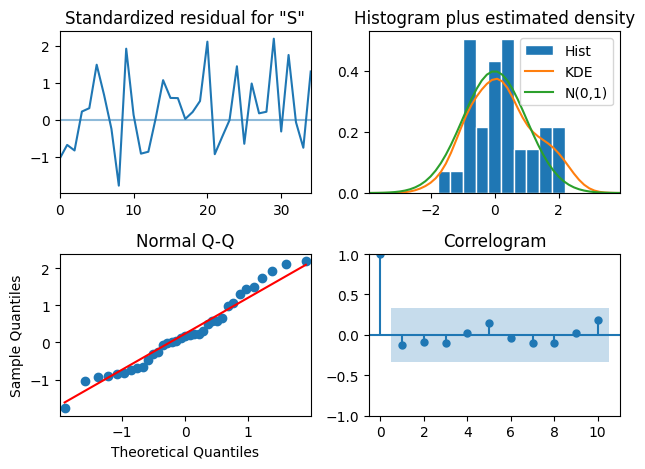

In [20]:
best_model = SARIMAX(dataset['Sales'], order=(5,1,0), simple_differencing=False)
res = best_model.fit(disp=False)
res.plot_diagnostics()
plt.tight_layout()
plt.show()

In [21]:
n_forecast = 5
predict = res.get_prediction(end=best_model.nobs + n_forecast)
predictions = predict.predicted_mean

dataset['forecasts'] = predictions[:-(n_forecast+1)]

mse = mean_squared_error(dataset['Sales'], dataset['forecasts'])
print(f"MSE contra los datos: {mse:.5f}")
dataset.head(15)

MSE contra los datos: 6824.46662


,Month,Sales,Sales_diff1,forecasts
0,1-01,266.0,NaN,0.000000
1,1-02,145.9,-120.1,263.519577
2,1-03,183.1,37.2,234.600988
3,1-04,119.3,-63.8,179.948283
4,1-05,180.3,61.0,164.110263
5,1-06,168.5,-11.8,145.707868
6,1-07,231.8,63.3,129.652208
7,1-08,224.5,-7.3,178.358061
8,1-09,192.8,-31.7,209.775296
9,1-10,122.9,-69.9,245.192030


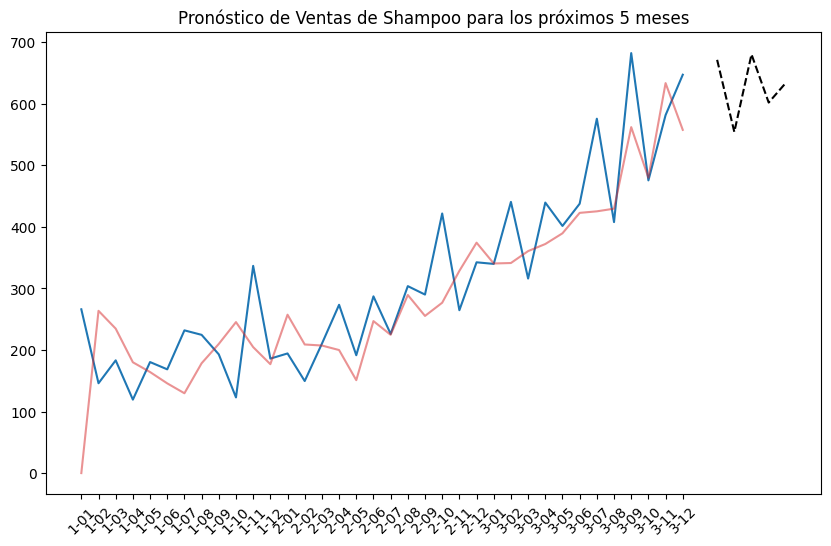

In [22]:
idx = np.arange(len(predict.predicted_mean))

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(dataset['Month'], dataset['Sales'], 'tab:blue', label='Historico')
ax.plot(dataset['Month'], dataset['forecasts'], 'tab:red', alpha=0.5, label='Pronóstico')
ax.plot(idx[-n_forecast:], predictions[-n_forecast:], 'k--', label='Pronóstico')
ax.set_title(f'Pronóstico de Ventas de Shampoo para los próximos {n_forecast} meses')
ax.tick_params(axis='x', labelrotation=45)
plt.show()

Aquí ya empezamos a ver una mejora significativa comparado con el modelo de regresión lineal simple!